In [1]:
import solar_getter
import pandas as pd
import json
import os
import itertools
import matplotlib.pyplot as plt
import functools
import random_fields
import numpy as np
import seaborn as sns

In [2]:
api_key = os.environ.get('NREL')
lat, lon= 42.3683452, -71.0957524
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed_10m_nwp,surface_air_temperature_nwp,solar_zenith_angle'
# Choose year of data
year = '2011'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.	interval = '30'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'James+Long'
# Your reason for using the NSRDB.
# Your email address
your_email = 'jjlong@mit.edu'
mailing_list = 'true'
reason_for_use = 'beta+testing'
your_affiliation = 'mit'
interval='30'

In [3]:
fname='testing'
meta, df = solar_getter.get_solar(fname, year=year, lat=lat, lon=lon,
                    leap_year=leap_year, interval=interval,
                    utc=utc, your_name=your_name, your_email=your_email,
                    your_affiliation=your_affiliation,
                    api_key=api_key, attributes=attributes)

metadata:  {'Pressure Units': 'mbar', 'Cloud Type 4': 'Super-Cooled Water', 'Fill Flag 5': 'Rayleigh Violation', 'Cloud Type 2': 'Fog', 'GHI Units': 'w/m2', 'Cloud Type 11': 'Dust', 'Cloud Type 9': 'Overshooting', 'Fill Flag 1': 'Missing Image', 'Elevation': 18, 'Cloud Type 1': 'Probably Clear', 'Fill Flag 3': 'Exceeds Clearsky', 'DHI Units': 'w/m2', 'Snow Depth Units': 'm', 'Dew Point Units': 'c', 'Clearsky DHI Units': 'w/m2', 'Clearsky GHI Units': 'w/m2', 'Time Zone': -5, 'Cloud Type 10': 'Unknown', 'Cloud Type 3': 'Water', 'Fill Flag 0': nan, 'Location ID': 1325726, 'City': '-', 'Source': 'NSRDB', 'Wind Direction Units': 'Degrees', 'Temperature Units': 'c', 'Cloud Type 12': 'Smoke', 'Cloud Type 5': 'Mixed', 'Cloud Type 8': 'Overlapping', 'Precipitable Water Units': 'mm', 'Country': '-', 'Cloud Type 0': 'Clear', 'Cloud Type -1': nan, 'State': '-', 'Local Time Zone': -5, 'Solar Zenith Angle Units': 'Degree', 'Latitude': 42.37, 'DNI Units': 'w/m2', 'Cloud Type 6': 'Opaque Ice', 'Fill F

In [4]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
converter = lambda v: float(v) if is_number(v) else v
df = pd.read_pickle('testing.pkl')
with open('testing.metadata.json') as f:
    meta = {k:converter(v) for k,v in json.load(f).items()}

In [5]:
cell_properties = {'system_capacity':2e-3 , 'azimuth':180 , 'tilt':0}
generated, dcnet,acnet = solar_getter.convert_to_energy(cell_properties,meta, df)

In [6]:
def slicer(wattage, start, duration):
    return itertools.islice(itertools.cycle(wattage), start, start+duration)

In [7]:
def runner(reducingseries,f):
    def wrapper(*args, **kwargs):
        current = reducingseries.pop(0)
        return f(current, *args, **kwargs)
    return wrapper
#make a note here - how this will work is that environment reset function
#will create a new battery dynamics function e.g.
#in Env init create the power series
#self.powerseries = solargetter.convert_to_energy(self.cell_properties, self.meta, self.df)
#then in reset function
#randomstart = random_start_generator()
#currentslice = slicer(self.powerseries, randomstart, duration)
#randomly_perturbed = random_perturber(current slice)
#episode_battery_runner = functools.partial(battery_dynamics, randomly_perturbed)
#self.episode_battery_dynamics = episode_battery_runner(battery_dynamics)
def battery_dynamics(generated_power, maxbatt, status, battery):
    discharge_voltage = 3.7 #Volts
    timeperiod = 0.5 #hours
    added_power =  generated_power*1000*timeperiod #mWh - generated is avg power in a timeperiod
    max_possible = maxbatt*discharge_voltage #mAh e.g. 2000mAh times 3.7 volts = 7400mW 
    on_power = 56+45+5#mAh
    off_power = 0.5#mAh
    if status == 2:#sleeping
        balance = added_power - off_power
        new_battery = min(battery+balance, maxbatt)
    else:#either pre-sleep or awake
        balance = added_power - on_power
        new_battery = max(0, battery+balance)
    return new_battery

In [8]:
def runner(reducingseries,f):
    def wrapper(*args, **kwargs):
        current = reducingseries.pop(0)
        return f(current, *args, **kwargs)
    return wrapper


In [9]:
runit = functools.partial(runner, [1,2,3,4])
def printer(first, second):
    print(first,second)  
runit(printer)('a')

1 a


In [30]:
def random_perturber(timeseries):
    psd_fun = functools.partial(random_fields.power_spectrum, 100)
    perturbation = random_fields.gaussian_proc(psd_fun, size=len(timeseries), scale =100)
    perturbation +=1 #perturbation around self value
    return np.multiply(timeseries, perturbation)

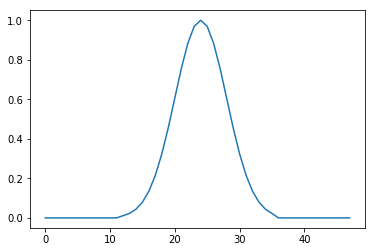

In [11]:
def gaussian(x):
    mu = 12
    sig = 2
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def emulate_sun():
    nighttime = 12*[0.0]
    daytime = [gaussian(0.5*i) for i in range(12,36)]
    return nighttime+daytime+nighttime
fig,ax = plt.subplots(1)
ax.plot(emulate_sun())

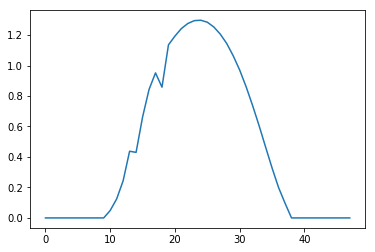

In [12]:
fig,ax = plt.subplots(1)
day = 200
ax.plot(dcnet.real[day*48:day*48+48])

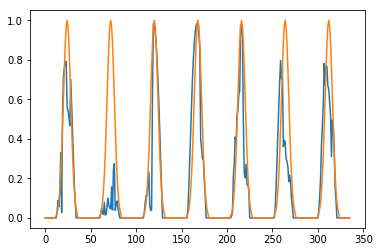

In [13]:
fig,ax = plt.subplots(1)
startday = 290
duration = 7
simmed = list(itertools.chain(*[emulate_sun() for i in range(duration)]))
ax.plot(dcnet.real[startday*48:(startday+duration)*48])
ax.plot(simmed)

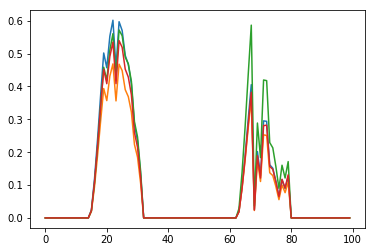

In [34]:
perturbed = [random_perturber(dcnet) for _ in range(4)]
fig,ax = plt.subplots(1)
#ax.plot(perturbed[0:512],label='variation')
for i in perturbed:
    ax.plot(i.real[0:100])
#ax.plot(dcnet[0:512], label='seed')
#sns.tsplot([i.real[0:48] for i in perturbed])

/home/jjlong/continuous/venv/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


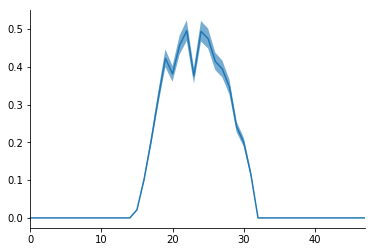

In [18]:
sns.tsplot([i.real[0:48] for i in perturbed],ci=95,err_style='ci_band', err_kws = {'alpha':0.6})
sns.despine()

In [ ]:
battery_capacity = 2000#mAh
max_batt = 10 #nondimensional
cap = lambda b:b*max_batt/battery_capacity

In [ ]:
cap(2000)